<a href="https://colab.research.google.com/github/LIYunzhe1408/Facial-Keypoint-Detection/blob/main/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data

In [1]:
# Fetch data
!mkdir data
!wget -P data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n data/train-test-data.zip -d data

mkdir: cannot create directory ‘data’: File exists
--2025-04-11 00:59:29--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.234.192, 52.217.173.88, 52.217.92.174, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.234.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘data/train-test-data.zip.1’

train-test-data.zip 100%[===================>] 322.93M  16.2MB/s    in 22s     

2025-04-11 00:59:52 (14.6 MB/s) - ‘data/train-test-data.zip.1’ saved [338613624/338613624]

Archive:  data/train-test-data.zip


# Setup Environment

In [ ]:
# No need if you are using colab

# !pip install matplotlib~=3.5.2
# !pip install scikit-image==0.19.2
# !pip install torch~=1.8.1
# !pip install torchvision~=0.9.1
# !pip install numpy~=1.21.6
# !pip install pillow~=9.1.1
# !pip install tqdm~=4.64.0
# !pip install jupyter==1.0.0
# !pip install opencv-python==4.6.0.66
# !pip install pandas==1.3.5


# Visualize the data

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


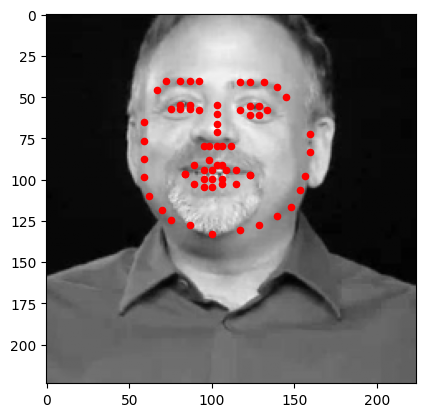

In [2]:
# importing the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.optim as optim
from tqdm import tqdm


# the transforms we defined in Notebook 1 are in the helper file `custom_transforms.py`
from custom_transforms import (
    Rescale,
    RandomCrop,
    NormalizeOriginal,
    ToTensor,
)

# the dataset we created in Notebook 1
from facial_keypoints_dataset import FacialKeypointsDataset



# defining the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose(
    [Rescale(250), RandomCrop(224), NormalizeOriginal(), ToTensor()]
)

training_keypoints_csv_path = os.path.join("data", "training_frames_keypoints.csv")
training_data_dir = os.path.join("data", "training")
test_keypoints_csv_path = os.path.join("data", "test_frames_keypoints.csv")
test_data_dir = os.path.join("data", "test")


# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(
    csv_file=training_keypoints_csv_path,
    root_dir=training_data_dir,
    transform=data_transform,
)
# load training data in batches
batch_size = 32
train_loader = DataLoader(
    transformed_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

# creating the test dataset
test_dataset = FacialKeypointsDataset(
    csv_file=test_keypoints_csv_path,
    root_dir=test_data_dir,
    transform=data_transform
)
# loading test data in batches
batch_size = 32
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

for i, data in enumerate(test_loader):
    sample = data
    image = sample['image'][0]
    keypoints = sample['keypoints'][0]
    # plot the image black and white
    plt.imshow(image.numpy().transpose(1, 2, 0), cmap='gray')
    plt.scatter(keypoints[:, 0]*50+100, keypoints[:, 1]*50+100, c='r', s=20)
    plt.show()
    break


# Train your model

In [8]:
from models import SimpleNet, Resnet18Grayscale, Resnet34Grayscale
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ========== VALIDATION FUNCTION ==========
def validate(net, val_loader, criterion):
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images = data["image"].cuda()
            key_pts = data["keypoints"].view(-1, 136).cuda()

            if isinstance(criterion, nn.MSELoss):
                images = images.type(torch.float32)
                key_pts = key_pts.type(torch.float32)

            outputs = net(images)
            loss = criterion(outputs, key_pts)
            val_loss += loss.item()

    return val_loss / len(val_loader)


# ========== TRAINING FUNCTION ==========
def train_net(net, n_epochs, criterion, optimizer, val_loader):
    train_losses = []
    val_losses = []

    net.train()
    net.cuda()

    for epoch in tqdm(range(n_epochs), desc="training"):
        running_loss = 0.0

        for data in tqdm(train_loader, desc=f"epoch {epoch}"):
            images = data["image"].cuda()
            key_pts = data["keypoints"].cuda()

            if isinstance(criterion, nn.MSELoss):
                images = images.type(torch.float32)
                key_pts = key_pts.type(torch.float32)

            key_pts = key_pts.view(key_pts.size(0), -1)

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, key_pts)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Compute epoch-level losses
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        epoch_val_loss = validate(net, val_loader, criterion)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses


# ===================================
# Part 1 Net
# Loss Function
# net_SmoothL1 = SimpleNet()
# net_MSELoss = SimpleNet()

# net_batch_64 = SimpleNet()
# net_LR_05 = SimpleNet()
# net_LR_00005 = SimpleNet()

# net_AdamW = SimpleNet()
# net_dropout_all_02 = SimpleNet()


# ========== HYPERPARAMETERS ==========
# n_epochs = 10
# optimizer_smoothL1 = optim.Adam(net_LR_00005.parameters(), lr=0.0005)
# optimizer_MSE = optim.Adam(net_MSELoss.parameters(), lr=0.001)
# optimizer = optim.AdamW(net_dropout_all_02.parameters(), lr=0.0005)


# ========== TRAIN MODELS ==========
# Loss Function
# SmoothL1_losses, val_SmoothL1_losses = train_net(net_SmoothL1, n_epochs, nn.SmoothL1Loss(), optimizer_smoothL1, test_loader)
# MSE_losses, val_MSE_losses = train_net(net_MSELoss, n_epochs, nn.MSELoss(), optimizer_MSE, test_loader)

# Batch Size
# LR_05_L1_loss, LR_05_L1_val_loss = train_net(net_LR_00005, n_epochs, nn.SmoothL1Loss(), optimizer_smoothL1, test_loader)

# AdamW_loss, AdamW_val_loss = train_net(net_AdamW, n_epochs, nn.SmoothL1Loss(), optimizer, test_loader)

# droupout_all_02_loss, droupout_all_02_val_loss = train_net(net_dropout_all_02, n_epochs, nn.SmoothL1Loss(), optimizer, test_loader)



# =================================Resnet
def train_resnet(resnet):
  n_epochs_backbone_freeze = 10
  n_epochs_entire = 10
  # Freeze Backbone first
  for param in resnet.backbone.parameters():
      param.requires_grad = False

  optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)
  loss, val_loss = train_net(resnet, n_epochs_backbone_freeze, nn.SmoothL1Loss(), optimizer, test_loader)

  temp_net = resnet

  # Fine-tune
  for param in resnet.backbone.parameters():
      param.requires_grad = True

  optimizer_fine_tune = optim.Adam(resnet.parameters(), lr=0.0001)
  fine_tune_loss, fine_tune_val_loss = train_net(resnet, n_epochs_entire, nn.SmoothL1Loss(), optimizer, test_loader)
  return loss, val_loss, fine_tune_loss, fine_tune_val_loss, temp_net, resnet


resnet18 = Resnet18Grayscale()
resnet34 = Resnet34Grayscale()

resnet18_loss, resnet18_val_loss, \
resnet18_fine_tune_loss, resnet18_fine_tune_val_loss, \
temp_net18, resnet18 = train_resnet(resnet18)


resnet34_loss, resnet34_val_loss, \
resnet34_fine_tune_loss, resnet34_fine_tune_val_loss, \
temp_net34, resnet34 = train_resnet(resnet34)

training:  10%|█         | 1/10 [00:15<02:20, 15.64s/it]

Epoch 1/10 | Train Loss: 0.1310 | Val Loss: 0.1142



training:  20%|██        | 2/10 [00:31<02:05, 15.63s/it]

Epoch 2/10 | Train Loss: 0.0869 | Val Loss: 0.0700



training:  30%|███       | 3/10 [00:46<01:49, 15.59s/it]

Epoch 3/10 | Train Loss: 0.0690 | Val Loss: 0.0616



training:  40%|████      | 4/10 [01:02<01:33, 15.53s/it]

Epoch 4/10 | Train Loss: 0.0646 | Val Loss: 0.0585



training:  50%|█████     | 5/10 [01:17<01:18, 15.60s/it]

Epoch 5/10 | Train Loss: 0.0583 | Val Loss: 0.0562



training:  60%|██████    | 6/10 [01:34<01:03, 15.77s/it]

Epoch 6/10 | Train Loss: 0.0584 | Val Loss: 0.0508



training:  70%|███████   | 7/10 [01:49<00:46, 15.56s/it]

Epoch 7/10 | Train Loss: 0.0568 | Val Loss: 0.0494



training:  80%|████████  | 8/10 [02:04<00:30, 15.49s/it]

Epoch 8/10 | Train Loss: 0.0546 | Val Loss: 0.0506



training:  90%|█████████ | 9/10 [02:19<00:15, 15.43s/it]

Epoch 9/10 | Train Loss: 0.0527 | Val Loss: 0.0505



training: 100%|██████████| 10/10 [02:35<00:00, 15.52s/it]


Epoch 10/10 | Train Loss: 0.0502 | Val Loss: 0.0601


training:  10%|█         | 1/10 [00:17<02:37, 17.55s/it]

Epoch 1/10 | Train Loss: 0.0701 | Val Loss: 0.0668



training:  20%|██        | 2/10 [00:33<02:14, 16.83s/it]

Epoch 2/10 | Train Loss: 0.0614 | Val Loss: 0.0486



training:  30%|███       | 3/10 [00:50<01:56, 16.61s/it]

Epoch 3/10 | Train Loss: 0.0555 | Val Loss: 0.0572



training:  40%|████      | 4/10 [01:06<01:39, 16.55s/it]

Epoch 4/10 | Train Loss: 0.0529 | Val Loss: 0.0453



training:  50%|█████     | 5/10 [01:24<01:24, 16.86s/it]

Epoch 5/10 | Train Loss: 0.0493 | Val Loss: 0.0441



training:  60%|██████    | 6/10 [01:40<01:07, 16.80s/it]

Epoch 6/10 | Train Loss: 0.0499 | Val Loss: 0.0426



training:  70%|███████   | 7/10 [01:57<00:50, 16.72s/it]

Epoch 7/10 | Train Loss: 0.0501 | Val Loss: 0.0489



training:  80%|████████  | 8/10 [02:13<00:33, 16.70s/it]

Epoch 8/10 | Train Loss: 0.0484 | Val Loss: 0.0486



training:  90%|█████████ | 9/10 [02:31<00:16, 16.88s/it]

Epoch 9/10 | Train Loss: 0.0477 | Val Loss: 0.0433



training: 100%|██████████| 10/10 [02:47<00:00, 16.78s/it]


Epoch 10/10 | Train Loss: 0.0454 | Val Loss: 0.0506


training:  10%|█         | 1/10 [00:18<02:42, 18.06s/it]

Epoch 1/10 | Train Loss: 0.1350 | Val Loss: 0.0991



training:  20%|██        | 2/10 [00:36<02:24, 18.11s/it]

Epoch 2/10 | Train Loss: 0.0865 | Val Loss: 0.0716



training:  30%|███       | 3/10 [00:53<02:04, 17.85s/it]

Epoch 3/10 | Train Loss: 0.0697 | Val Loss: 0.0581



training:  40%|████      | 4/10 [01:11<01:46, 17.79s/it]

Epoch 4/10 | Train Loss: 0.0646 | Val Loss: 0.0584



training:  50%|█████     | 5/10 [01:30<01:30, 18.07s/it]

Epoch 5/10 | Train Loss: 0.0570 | Val Loss: 0.0554



training:  60%|██████    | 6/10 [01:47<01:11, 17.98s/it]

Epoch 6/10 | Train Loss: 0.0551 | Val Loss: 0.0572



training:  70%|███████   | 7/10 [02:05<00:53, 17.87s/it]

Epoch 7/10 | Train Loss: 0.0563 | Val Loss: 0.0504



training:  80%|████████  | 8/10 [02:24<00:36, 18.09s/it]

Epoch 8/10 | Train Loss: 0.0522 | Val Loss: 0.0449



training:  90%|█████████ | 9/10 [02:41<00:17, 17.97s/it]

Epoch 9/10 | Train Loss: 0.0514 | Val Loss: 0.0452



training: 100%|██████████| 10/10 [03:03<00:00, 18.39s/it]


Epoch 10/10 | Train Loss: 0.0502 | Val Loss: 0.0430


training:  10%|█         | 1/10 [00:25<03:46, 25.20s/it]

Epoch 1/10 | Train Loss: 0.0752 | Val Loss: 0.0662



training:  20%|██        | 2/10 [00:47<03:06, 23.32s/it]

Epoch 2/10 | Train Loss: 0.0648 | Val Loss: 0.0554



training:  30%|███       | 3/10 [01:10<02:41, 23.12s/it]

Epoch 3/10 | Train Loss: 0.0596 | Val Loss: 0.0549



training:  40%|████      | 4/10 [01:32<02:17, 22.94s/it]

Epoch 4/10 | Train Loss: 0.0594 | Val Loss: 0.0578



training:  50%|█████     | 5/10 [01:54<01:52, 22.42s/it]

Epoch 5/10 | Train Loss: 0.0575 | Val Loss: 0.0533



training:  60%|██████    | 6/10 [02:16<01:29, 22.32s/it]

Epoch 6/10 | Train Loss: 0.0557 | Val Loss: 0.0466



training:  70%|███████   | 7/10 [02:38<01:06, 22.29s/it]

Epoch 7/10 | Train Loss: 0.0534 | Val Loss: 0.0469



training:  80%|████████  | 8/10 [03:00<00:44, 22.21s/it]

Epoch 8/10 | Train Loss: 0.0572 | Val Loss: 0.0689



training:  90%|█████████ | 9/10 [03:22<00:22, 22.17s/it]

Epoch 9/10 | Train Loss: 0.0532 | Val Loss: 0.0545



training: 100%|██████████| 10/10 [03:44<00:00, 22.46s/it]

Epoch 10/10 | Train Loss: 0.0533 | Val Loss: 0.0474


In [ ]:
# from models import SimpleNet

# net_SmoothL1 = SimpleNet()
# net_MSELoss = SimpleNet()
# # net = Resnet18Grayscale()
# # net = Dinov2_grayscale()


# def train_net(net, n_epochs, criterion, optimizer):
#     losses = []
#     # prepare the net for training
#     net.train()
#     net.cuda()

#     # loop over the dataset multiple times
#     for epoch in tqdm(range(n_epochs), desc="training"):

#         running_loss = 0.0

#         # train on batches of data, assumes we already have train_loader
#         batch_i = 0
#         for data in tqdm(train_loader, desc="epoch {}".format(epoch)):

#             # get the input images and their corresponding labels
#             images = data["image"]
#             key_pts = data["keypoints"]
#             # Move images and keypoints to GPU
#             images = images.cuda()
#             key_pts = key_pts.cuda()

#             if isinstance(criterion, nn.MSELoss):
#               images = images.type(torch.float32)
#               key_pts = key_pts.type(torch.float32)

#             # TODO: implement training code here
#             key_pts = key_pts.view(key_pts.size(0), -1)

#             optimizer.zero_grad()              # zero the parameter gradients
#             outputs = net(images)              # forward pass
#             loss = criterion(outputs, key_pts) # compute loss
#             loss.backward()                    # backward pass
#             optimizer.step()                   # update weights

#             # print loss statistics
#             running_loss += loss.item()

#             batch_i += 1

#         epoch_loss = running_loss / len(train_loader)
#         losses.append(epoch_loss)

#     return losses
#     print("Finished Training")

# # train the network
# n_epochs = 2  # we start at small values, then we increase when we fixed the model structure and hyperparams

# # Defining the loss and optimization
# criterion = nn.SmoothL1Loss()
# criterion = nn.MSELoss()
# optimizer_smoothL1 = optim.Adam(net_SmoothL1.parameters(), lr=0.001)
# optimizer_MSE = optim.Adam(net_MSELoss.parameters(), lr=0.001)

# SmoothL1_losses = train_net(net_SmoothL1, n_epochs, nn.SmoothL1Loss(), optimizer_smoothL1)
# MSE_losses = train_net(net_MSELoss, n_epochs, nn.MSELoss(), optimizer_MSE)

training: 100%|██████████| 2/2 [00:30<00:00, 15.18s/it]


# Visualize the model predictions

## Loss function

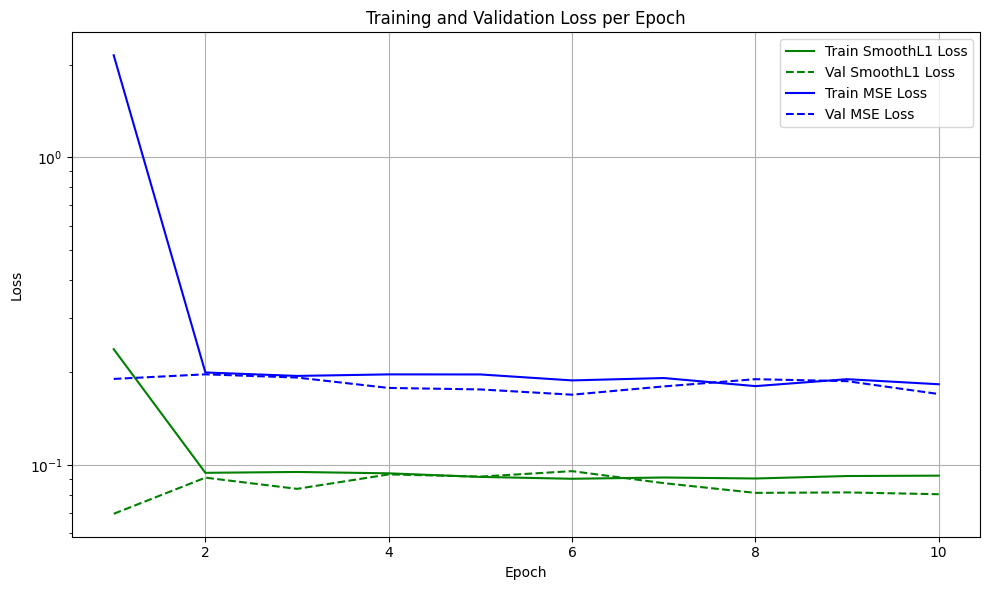

Final training loss: 0.09242875540443223, 0.18315610224338172
Final val loss: 0.08044344028357801, 0.17023054251865466
Best val loss (SmoothL1): 0.06948532591530011, epoch#: 0
Best val loss (MSE): 0.1693831400147506, epoch#: 5


In [ ]:
# import matplotlib.pyplot as plt

# epochs = range(1, len(SmoothL1_losses) + 1)

# plt.figure(figsize=(10, 6))

# # SmoothL1 loss curves
# plt.plot(epochs, SmoothL1_losses, label='Train SmoothL1 Loss', color='green', linestyle='-')
# plt.plot(epochs, val_SmoothL1_losses, label='Val SmoothL1 Loss', color='green', linestyle='--')

# # MSE loss curves
# plt.plot(epochs, MSE_losses, label='Train MSE Loss', color='blue', linestyle='-')
# plt.plot(epochs, val_MSE_losses, label='Val MSE Loss', color='blue', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {SmoothL1_losses[-1]}, {MSE_losses[-1]}')
# print(f'Final val loss: {val_SmoothL1_losses[-1]}, {val_MSE_losses[-1]}')

# best_val_loss = min(val_SmoothL1_losses)
# best_epoch = val_SmoothL1_losses.index(best_val_loss)
# print(f'Best val loss (SmoothL1): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(val_MSE_losses)
# best_epoch = val_MSE_losses.index(best_val_loss)
# print(f'Best val loss (MSE): {best_val_loss}, epoch#: {best_epoch}')


## Batch Size

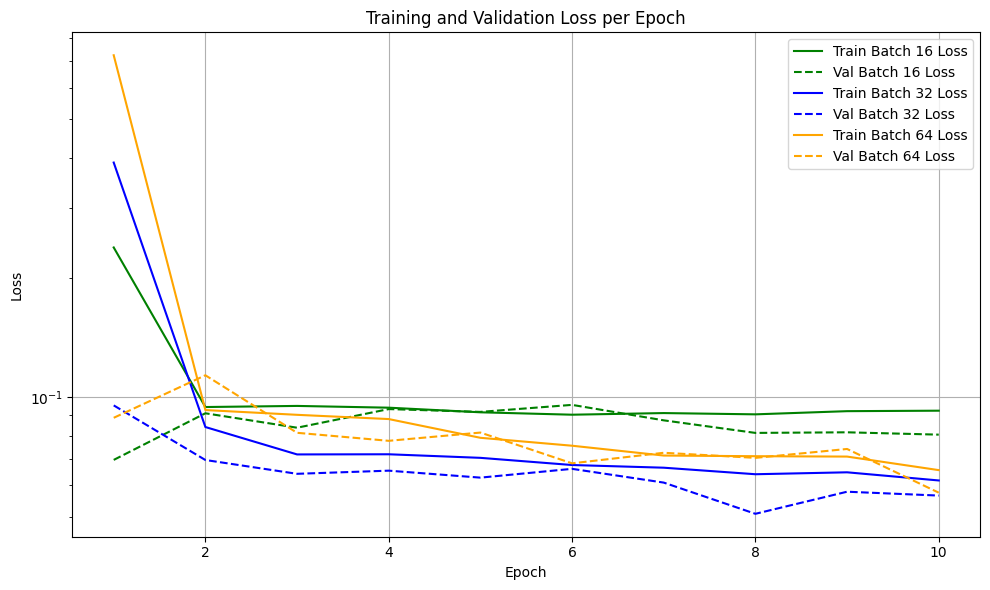

Final training loss: 0.09242875540443223, 0.06167978404789199, 0.06548963366943926
Final val loss: 0.08044344028357801, 0.056507733884966695, 0.05746516709373932
Best val loss (Batch 16): 0.06948532591530011, epoch#: 0
Best val loss (Batch 32): 0.05084166460482429, epoch#: 7
Best val loss (Batch 64): 0.05746516709373932, epoch#: 9


In [ ]:
# batch_16_L1_loss = SmoothL1_losses
# batch_16_L1_val_loss = val_SmoothL1_losses
# batch_16_L1_net = net_SmoothL1

# import matplotlib.pyplot as plt

# epochs = range(1, len(batch_16_L1_loss) + 1)

# plt.figure(figsize=(10, 6))

# # 16 loss curves
# plt.plot(epochs, batch_16_L1_loss, label='Train Batch 16 Loss', color='green', linestyle='-')
# plt.plot(epochs, batch_16_L1_val_loss, label='Val Batch 16 Loss', color='green', linestyle='--')

# # 32 loss curves
# plt.plot(epochs, batch_32_L1_loss, label='Train Batch 32 Loss', color='blue', linestyle='-')
# plt.plot(epochs, batch_32_L1_val_loss, label='Val Batch 32 Loss', color='blue', linestyle='--')

# # 64 loss curves
# plt.plot(epochs, batch_64_L1_loss, label='Train Batch 64 Loss', color='orange', linestyle='-')
# plt.plot(epochs, batch_64_L1_val_loss, label='Val Batch 64 Loss', color='orange', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {batch_16_L1_loss[-1]}, {batch_32_L1_loss[-1]}, {batch_64_L1_loss[-1]}')
# print(f'Final val loss: {batch_16_L1_val_loss[-1]}, {batch_32_L1_val_loss[-1]}, {batch_64_L1_val_loss[-1]}')

# best_val_loss = min(batch_16_L1_val_loss)
# best_epoch = batch_16_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (Batch 16): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(batch_32_L1_val_loss)
# best_epoch = batch_32_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (Batch 32): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(batch_64_L1_val_loss)
# best_epoch = batch_64_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (Batch 64): {best_val_loss}, epoch#: {best_epoch}')

## Learning Rate

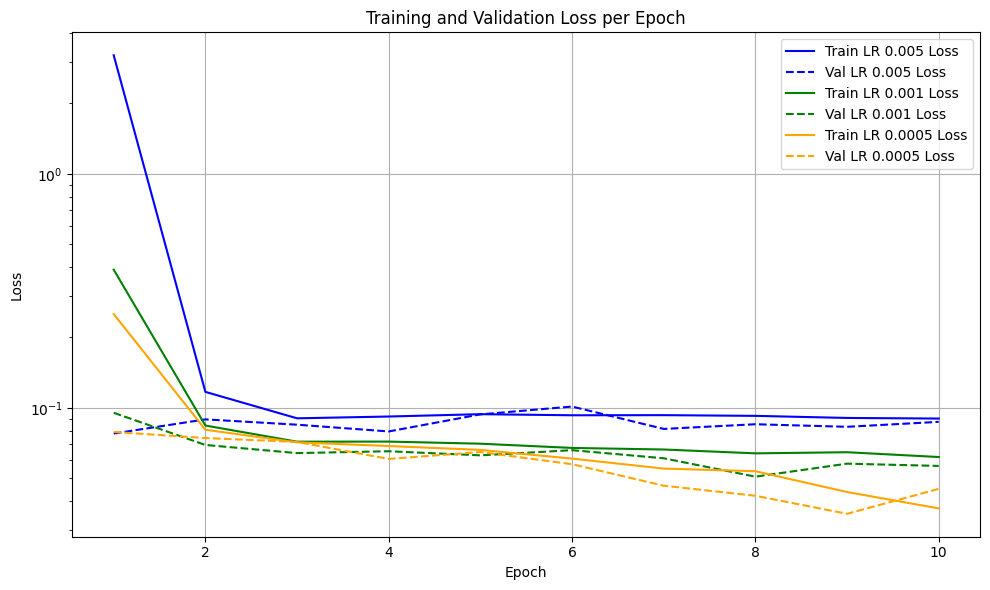

Final training loss: 0.037213279466794265, 0.06167978404789199, 0.09005379214909241
Final val loss: 0.04509976361784689, 0.056507733884966695, 0.08716710537090032
Best val loss (LR 0.005): 0.035286272131784334, epoch#: 8
Best val loss (LR 0.001): 0.05084166460482429, epoch#: 7
Best val loss (LR 0.0005): 0.07772143766586313, epoch#: 0


In [ ]:
# import matplotlib.pyplot as plt

# epochs = range(1, len(LR_05_L1_loss) + 1)

# plt.figure(figsize=(10, 6))

# # 16 loss curves
# plt.plot(epochs, LR_00005_L1_loss, label='Train LR 0.005 Loss', color='blue', linestyle='-')
# plt.plot(epochs, LR_00005_L1_val_loss, label='Val LR 0.005 Loss', color='blue', linestyle='--')

# # 32 loss curves
# plt.plot(epochs, batch_32_L1_loss, label='Train LR 0.001 Loss', color='green', linestyle='-')
# plt.plot(epochs, batch_32_L1_val_loss, label='Val LR 0.001 Loss', color='green', linestyle='--')

# # # 64 loss curves
# plt.plot(epochs, LR_05_L1_loss, label='Train LR 0.0005 Loss', color='orange', linestyle='-')
# plt.plot(epochs, LR_05_L1_val_loss, label='Val LR 0.0005 Loss', color='orange', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {LR_05_L1_loss[-1]}, {batch_32_L1_loss[-1]}, {LR_00005_L1_loss[-1]}')
# print(f'Final val loss: {LR_05_L1_val_loss[-1]}, {batch_32_L1_val_loss[-1]}, {LR_00005_L1_val_loss[-1]}')

# best_val_loss = min(LR_05_L1_val_loss)
# best_epoch = LR_05_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (LR 0.005): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(batch_32_L1_val_loss)
# best_epoch = batch_32_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (LR 0.001): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(LR_00005_L1_val_loss)
# best_epoch = LR_00005_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (LR 0.0005): {best_val_loss}, epoch#: {best_epoch}')

## Optimizer

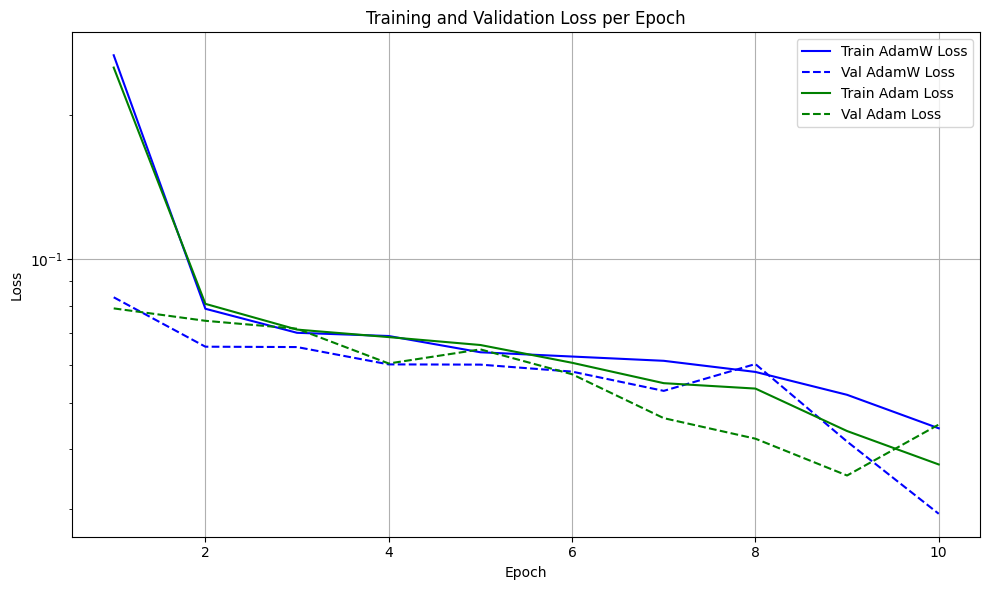

Final training loss: 0.037213279466794265, 0.04429485004647331
Final val loss: 0.04509976361784689, 0.02934233347240932
Best val loss (Adam): 0.035286272131784334, epoch#: 8
Best val loss (AdamW): 0.02934233347240932, epoch#: 9


In [ ]:
# import matplotlib.pyplot as plt

# epochs = range(1, len(LR_05_L1_loss) + 1)

# plt.figure(figsize=(10, 6))

# # 16 loss curves
# plt.plot(epochs, AdamW_loss, label='Train AdamW Loss', color='blue', linestyle='-')
# plt.plot(epochs, AdamW_val_loss, label='Val AdamW Loss', color='blue', linestyle='--')

# # # 64 loss curves
# plt.plot(epochs, LR_05_L1_loss, label='Train Adam Loss', color='green', linestyle='-')
# plt.plot(epochs, LR_05_L1_val_loss, label='Val Adam Loss', color='green', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {LR_05_L1_loss[-1]}, {AdamW_loss[-1]}')
# print(f'Final val loss: {LR_05_L1_val_loss[-1]}, {AdamW_val_loss[-1]}')

# best_val_loss = min(LR_05_L1_val_loss)
# best_epoch = LR_05_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (Adam): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(AdamW_val_loss)
# best_epoch = AdamW_val_loss.index(best_val_loss)
# print(f'Best val loss (AdamW): {best_val_loss}, epoch#: {best_epoch}')

In [ ]:
# import json

# with open("adamw_losses.json", "w") as f:
#     json.dump({
#         "train_loss": AdamW_loss,
#         "val_loss": AdamW_val_loss
#     }, f)

## Droupout

In [ ]:
# import json
# with open("adamw_losses.json", "r") as f:
#     loss_data = json.load(f)

# AdamW_loss = loss_data["train_loss"]
# AdamW_val_loss = loss_data["val_loss"]

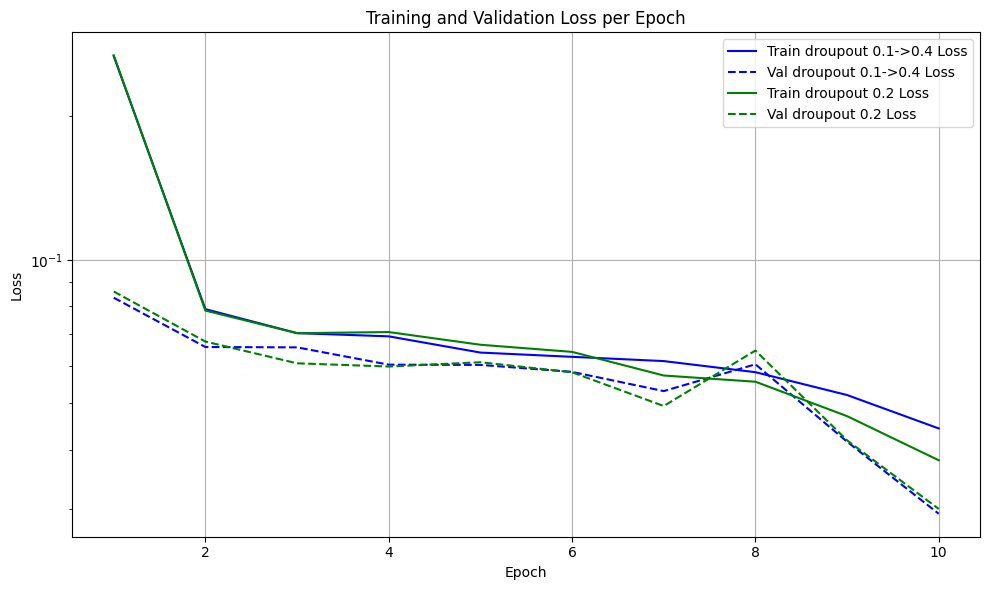

Final training loss: 0.03798806185916372, 0.04429485004647331
Final val loss: 0.030033955374372284, 0.02934233347240932
Best val loss (all 0.2): 0.030033955374372284, epoch#: 9
Best val loss (0.1->0.4): 0.02934233347240932, epoch#: 9


In [ ]:
# import matplotlib.pyplot as plt

# epochs = range(1, len(AdamW_loss) + 1)

# plt.figure(figsize=(10, 6))

# # 16 loss curves
# plt.plot(epochs, AdamW_loss, label='Train droupout 0.1->0.4 Loss', color='blue', linestyle='-')
# plt.plot(epochs, AdamW_val_loss, label='Val droupout 0.1->0.4 Loss', color='blue', linestyle='--')

# # # 64 loss curves
# plt.plot(epochs, droupout_all_02_loss, label='Train droupout 0.2 Loss', color='green', linestyle='-')
# plt.plot(epochs, droupout_all_02_val_loss, label='Val droupout 0.2 Loss', color='green', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {droupout_all_02_loss[-1]}, {AdamW_loss[-1]}')
# print(f'Final val loss: {droupout_all_02_val_loss[-1]}, {AdamW_val_loss[-1]}')

# best_val_loss = min(droupout_all_02_val_loss)
# best_epoch = droupout_all_02_val_loss.index(best_val_loss)
# print(f'Best val loss (all 0.2): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(AdamW_val_loss)
# best_epoch = AdamW_val_loss.index(best_val_loss)
# print(f'Best val loss (0.1->0.4): {best_val_loss}, epoch#: {best_epoch}')

## ResNet

In [9]:
import json

with open("resnet_losses.json", "w") as f:
    json.dump({
        "resnet18_backbone_freeze_train_loss": resnet18_loss,
        "resnet18_backbone_freeze_val_loss": resnet18_val_loss,
        "resnet34_backbone_freeze_train_loss": resnet34_loss,
        "resnet34_backbone_freeze_val_loss": resnet34_val_loss,
        "resnet18_train_loss": resnet18_fine_tune_loss,
        "resnet18_val_loss": resnet18_fine_tune_val_loss,
        "resnet34_train_loss": resnet34_fine_tune_loss,
        "resnet34_val_loss": resnet34_fine_tune_val_loss
    }, f)

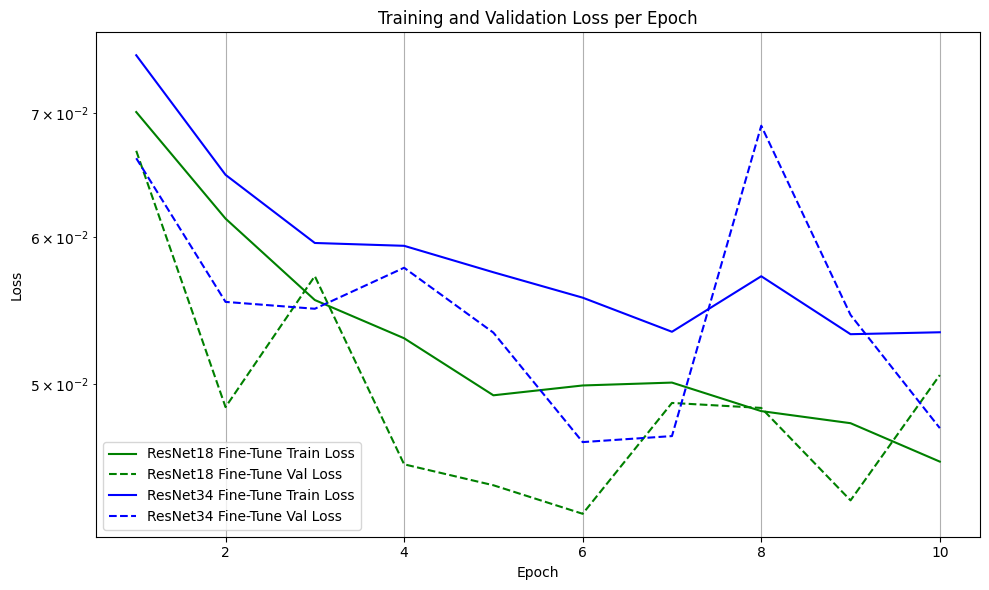

Final training loss: 0.053342020804576964, 0.045440740347552126
Final val loss: 0.047367172527770694, 0.050587124428471235
Best val loss: 0.04655370100328554, epoch#: 5
Best val loss: 0.04259537650911668, epoch#: 5


In [10]:
import matplotlib.pyplot as plt

epochs = range(1, len(resnet18_fine_tune_loss) + 1)

plt.figure(figsize=(10, 6))


# plt.plot(epochs, resnet18_loss, label='ResNet18 Frozen Backbone Train Loss', color='blue', linestyle='-')
# plt.plot(epochs, resnet18_val_loss, label='ResNet18 Frozen Backbone Val Loss', color='blue', linestyle='--')


plt.plot(epochs, resnet18_fine_tune_loss, label='ResNet18 Fine-Tune Train Loss', color='green', linestyle='-')
plt.plot(epochs, resnet18_fine_tune_val_loss, label='ResNet18 Fine-Tune Val Loss', color='green', linestyle='--')
plt.plot(epochs, resnet34_fine_tune_loss, label='ResNet34 Fine-Tune Train Loss', color='blue', linestyle='-')
plt.plot(epochs, resnet34_fine_tune_val_loss, label='ResNet34 Fine-Tune Val Loss', color='blue', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'Final training loss: {resnet34_fine_tune_loss[-1]}, {resnet18_fine_tune_loss[-1]}')
print(f'Final val loss: {resnet34_fine_tune_val_loss[-1]}, {resnet18_fine_tune_val_loss[-1]}')

best_val_loss = min(resnet34_fine_tune_val_loss)
best_epoch = resnet34_fine_tune_val_loss.index(best_val_loss)
print(f'Best val loss: {best_val_loss}, epoch#: {best_epoch}')

best_val_loss = min(resnet18_fine_tune_val_loss)
best_epoch = resnet18_fine_tune_val_loss.index(best_val_loss)
print(f'Best val loss: {best_val_loss}, epoch#: {best_epoch}')

In [11]:
from torch.nn import MSELoss

def calcMSE(net):
  net.eval()
  net.cuda()
  mse = MSELoss()
  total_mse = 0.0
  with torch.no_grad():
      for data in test_loader:
          images = data['image'].cuda()
          key_pts = data['keypoints'].view(-1, 136).cuda()
          outputs = net(images)
          total_mse += mse(outputs, key_pts).item()

  mean_mse = total_mse / len(test_loader)
  print(f"Test Mean Squared Error: {mean_mse:.4f}")
# calcMSE(batch_16_L1_net)
# calcMSE(net_batch_32)
# calcMSE(net_LR_05)
# calcMSE(net_LR_00005)
# calcMSE(net_AdamW)
# calcMSE(net_batch_64)
# calcMSE(net_dropout_all_02)
calcMSE(temp_net18)
calcMSE(resnet18)
calcMSE(temp_net34)
calcMSE(resnet34)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Mean Squared Error: 0.1069
Test Mean Squared Error: 0.1179
Test Mean Squared Error: 0.1113
Test Mean Squared Error: 0.1089


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


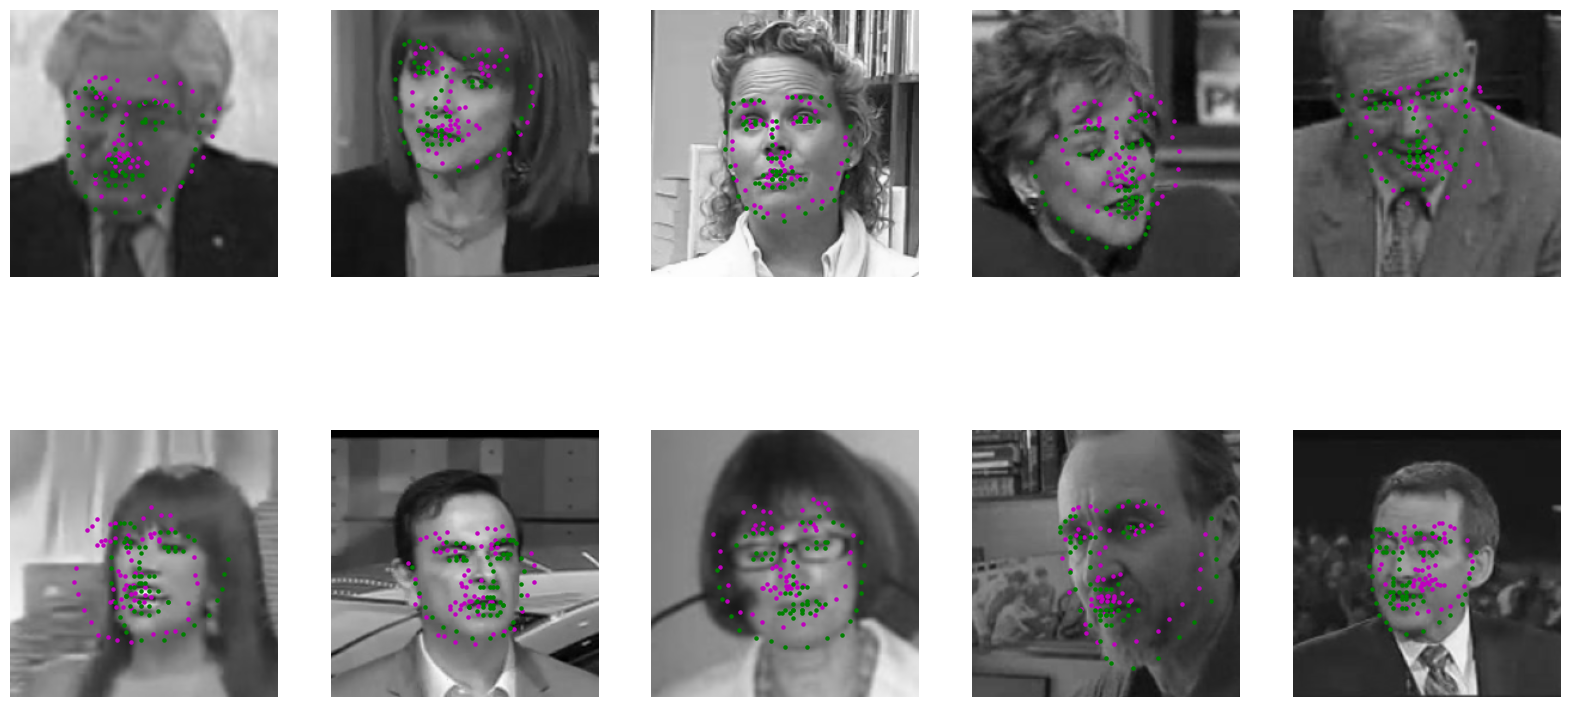

In [16]:

def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """
    Show image with predicted keypoints and optionally ground truth keypoints
    """
    # Convert grayscale to RGB if needed
    if len(image.shape) == 2:
        image = np.stack([image]*3, axis=2)

    plt.imshow(image*255, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')

    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


# test the model on a batch of test images
def net_sample_output(model, test_loader):

    # iterate through the test dataset
    for i, sample in enumerate(test_loader):

        # getting sample data: images and ground truth keypoints
        images = sample["image"]
        key_pts = sample["keypoints"]

        # converting images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forwarding pass to get net output
        output_pts = model(images)

        # reshaping to batch_size x 68 x 2 pts # (136*1) => (68*2)
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)

        # break after first image is tested
        if i == 0:
            return (
                images,
                output_pts,
                key_pts,
            )  # images, predicted key points, real keypoints

# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    plt.figure(figsize=(20, 10))
    for i in range(batch_size):
        ax = plt.subplot(batch_size // 5, 5, i + 1)

        # un-transform the image data
        image = test_images[i].data  # get the image from its Variable wrapper
        image = image.numpy()  # convert to numpy array from a Tensor
        image = np.transpose(
            image, (1, 2, 0)
        )  # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()

        # undo normalization of keypoints
        predicted_key_pts = predicted_key_pts * 50.0 + 100

        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]
            ground_truth_pts = ground_truth_pts * 50.0 + 100

        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)

        plt.axis("off")

    plt.show()


net = resnet34
# get a sample of test data again
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
test_images, test_outputs, gt_pts = net_sample_output(net.cpu(), test_loader)

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

# visualize the test output
visualize_output(test_images, test_outputs, gt_pts)

# Training UNet with Heatmaps

In [ ]:
# importing the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.optim as optim
from tqdm import tqdm


# the transforms we defined in Notebook 1 are in the helper file `custom_transforms.py`
from custom_transforms import (
    Rescale,
    RandomCrop,
    NormalizeOriginal,
    ToTensor,
)

# the dataset we created in Notebook 1
from facial_keypoints_dataset import FacialKeypointsHeatmapDataset



# defining the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose(
    [Rescale(250), RandomCrop(224), NormalizeOriginal(), ToTensor()]
)

training_keypoints_csv_path = os.path.join("data", "training_frames_keypoints.csv")
training_data_dir = os.path.join("data", "training")
test_keypoints_csv_path = os.path.join("data", "test_frames_keypoints.csv")
test_data_dir = os.path.join("data", "test")


# create the transformed dataset
transformed_dataset = FacialKeypointsHeatmapDataset(
    csv_file=training_keypoints_csv_path,
    root_dir=training_data_dir,
    transform=data_transform,
    output_size=224
)
# load training data in batches
batch_size = 16
train_loader = DataLoader(
    transformed_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

# creating the test dataset
test_dataset = FacialKeypointsHeatmapDataset(
    csv_file=test_keypoints_csv_path,
    root_dir=test_data_dir,
    transform=data_transform,
    output_size=224
)
# loading test data in batches
batch_size = 16
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

for i, data in enumerate(test_loader):
    sample = data
    image = sample['image'][0]
    keypoints = sample['keypoints'][0]
    # plot the image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0), cmap='gray')
    plt.scatter(keypoints[:, 0]*50+100, keypoints[:, 1]*50+100, c='r', s=20)
    # show the heatmaps
    plt.subplot(1, 2, 2)
    heatmaps = sample['heatmaps'][0].sum(dim=0, keepdim=True)
    plt.imshow(heatmaps.numpy().transpose(1, 2, 0))
    plt.show()
    break


In [ ]:
# TODO: training code for UNet with heatmaps

In [ ]:
# TODO: visualize your predictions